<a href="https://colab.research.google.com/github/AbirTarique/Courses-/blob/master/Digital_Health_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Digital Health Assignment. 
( Predicting length of stay for short term and long term patient )
If Length of Stay>= 7 then the patient will be termed as long term
If Length of Stay <7 then the patient will be short term.


At first loading the important packages 

In [ ]:
import pandas as pd
import numpy as np

Authenticating From google collab 

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project mimicpractice df
WITH 
icustay AS (SELECT HADM_ID, SUM(LOS) AS LOS_ICU FROM `physionet-data.mimiciii_clinical.icustays` GROUP BY HADM_ID), 
callout AS (SELECT HADM_ID, COUNT(HADM_ID) AS CALLOUT_COUNT FROM  `physionet-data.mimiciii_clinical.callout` GROUP BY HADM_ID),
diags AS (SELECT HADM_ID, COUNT(HADM_ID) AS DIAG_COUNT FROM `physionet-data.mimiciii_clinical.diagnoses_icd` GROUP BY HADM_ID),
preps AS (SELECT HADM_ID, COUNT(HADM_ID) AS PRES_COUNT FROM `physionet-data.mimiciii_clinical.prescriptions` GROUP BY HADM_ID),
procs AS (SELECT HADM_ID, COUNT(HADM_ID) AS PROC_COUNT FROM `physionet-data.mimiciii_clinical.procedures_icd` GROUP BY HADM_ID),
cpts AS (SELECT HADM_ID, COUNT(HADM_ID) AS CPT_COUNT FROM `physionet-data.mimiciii_clinical.cptevents` GROUP BY HADM_ID),
labs AS (SELECT HADM_ID, COUNT(HADM_ID) AS LAB_COUNT FROM `physionet-data.mimiciii_clinical.labevents` GROUP BY HADM_ID),
inputs_cv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_CV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_cv` GROUP BY HADM_ID),
inputs_mv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_MV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_mv` GROUP BY HADM_ID),
outputs AS (SELECT HADM_ID, COUNT(HADM_ID) AS OUTPUT_COUNT FROM `physionet-data.mimiciii_clinical.outputevents` GROUP BY HADM_ID),
transfers AS (SELECT HADM_ID, COUNT(HADM_ID) AS TRANSFER_COUNT FROM `physionet-data.mimiciii_clinical.transfers` GROUP BY HADM_ID),
micros AS (SELECT HADM_ID, COUNT(HADM_ID) AS MICRO_COUNT FROM `physionet-data.mimiciii_clinical.microbiologyevents` GROUP BY HADM_ID),
diafeature AS (WITH co_dx AS
(
	SELECT subject_id, hadm_id
  , MAX(
    	CASE
        -- septicemia
    		WHEN substring(icd9_code,1,3) = '038' THEN 1
        -- septicemic, bacteremia, disseminated fungal infection, disseminated candida infection
				-- NOTE: the paper specifies 020.0 ... but this is bubonic plague
				-- presumably, they meant 020.2, which is septicemic plague
        WHEN substring(icd9_code,1,4) in ('0202','7907','1179','1125') THEN 1
        -- disseminated fungal endocarditis
        WHEN substring(icd9_code,1,5) = '11281' THEN 1
      ELSE 0 END
    ) AS sepsis
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('7991') THEN 1
        WHEN substring(icd9_code,1,5) in ('51881','51882','51885','78609') THEN 1
      ELSE 0 END
    ) AS respiratory
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('4580','7855','4580','4588','4589','7963') THEN 1
        WHEN substring(icd9_code,1,5) in ('785.51','785.59') THEN 1
      ELSE 0 END
    ) AS cardiovascular
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('584','580','585') THEN 1
      ELSE 0 END
    ) AS renal
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('570') THEN 1
        WHEN substring(icd9_code,1,4) in ('5722','5733') THEN 1
      ELSE 0 END
    ) AS hepatic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('2862','2866','2869','2873','2874','2875') THEN 1
      ELSE 0 END
    ) AS hematologic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('2762') THEN 1
      ELSE 0 END
    ) AS metabolic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('293') THEN 1
        WHEN substring(icd9_code,1,4) in ('3481','3483') THEN 1
        WHEN substring(icd9_code,1,5) in ('78001','78009') THEN 1
      ELSE 0 END
    ) AS neurologic
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
  GROUP BY subject_id, hadm_id
)
-- procedure codes:
-- "96.7 - Ventilator management"
-- translated:
--    9670	Continuous invasive mechanical ventilation of unspecified duration
--    9671	Continuous invasive mechanical ventilation for less than 96 consecutive hours
--    9672	Continuous invasive mechanical ventilation for 96 consecutive hours or more
-- "39.95 - Hemodialysis"
--    3995	Hemodialysis
-- "89.14 - Electroencephalography"
--    8914	Electroencephalogram
, co_proc as
(
  SELECT subject_id, hadm_id
  , MAX(CASE WHEN substring(icd9_code,1,3) = '967' then 1 ELSE 0 END) as respiratory
  , MAX(CASE WHEN substring(icd9_code,1,4) = '3995' then 1 ELSE 0 END) as renal
  , MAX(CASE WHEN substring(icd9_code,1,4) = '8914' then 1 ELSE 0 END) as neurologic
  FROM  `physionet-data.mimiciii_clinical.procedures_icd`
  GROUP BY subject_id, hadm_id
)
select adm.subject_id, adm.hadm_id
, co_dx.sepsis
, CASE
    WHEN co_dx.respiratory = 1 OR co_proc.respiratory = 1
      OR co_dx.cardiovascular = 1
      OR co_dx.renal = 1 OR co_proc.renal = 1
      OR co_dx.hepatic = 1
      OR co_dx.hematologic = 1
      OR co_dx.metabolic = 1
      OR co_dx.neurologic = 1 OR co_proc.neurologic = 1
    THEN 1
  ELSE 0 END as organ_failure
, case when co_dx.respiratory = 1 or co_proc.respiratory = 1 then 1 else 0 end as respiratory
, co_dx.cardiovascular
, case when co_dx.renal = 1 or co_proc.renal = 1 then 1 else 0 end as renal
, co_dx.hepatic
, co_dx.hematologic
, co_dx.metabolic
, case when co_dx.neurologic = 1 or co_proc.neurologic = 1 then 1 else 0 end as neurologic
FROM `physionet-data.mimiciii_clinical.admissions` adm
left join co_dx
  on adm.hadm_id = co_dx.hadm_id
left join co_proc
  on adm.hadm_id = co_proc.hadm_id),
vitals as (
SELECT pvt.subject_id, pvt.hadm_id, pvt.icustay_id
-- Easier names
, min(case when VitalID = 1 then valuenum else null end) as HeartRate_Min
, max(case when VitalID = 1 then valuenum else null end) as HeartRate_Max
, avg(case when VitalID = 1 then valuenum else null end) as HeartRate_Mean
, min(case when VitalID = 2 then valuenum else null end) as SysBP_Min
, max(case when VitalID = 2 then valuenum else null end) as SysBP_Max
, avg(case when VitalID = 2 then valuenum else null end) as SysBP_Mean
, min(case when VitalID = 3 then valuenum else null end) as DiasBP_Min
, max(case when VitalID = 3 then valuenum else null end) as DiasBP_Max
, avg(case when VitalID = 3 then valuenum else null end) as DiasBP_Mean
, min(case when VitalID = 4 then valuenum else null end) as MeanBP_Min
, max(case when VitalID = 4 then valuenum else null end) as MeanBP_Max
, avg(case when VitalID = 4 then valuenum else null end) as MeanBP_Mean
, min(case when VitalID = 5 then valuenum else null end) as RespRate_Min
, max(case when VitalID = 5 then valuenum else null end) as RespRate_Max
, avg(case when VitalID = 5 then valuenum else null end) as RespRate_Mean
, min(case when VitalID = 6 then valuenum else null end) as TempC_Min
, max(case when VitalID = 6 then valuenum else null end) as TempC_Max
, avg(case when VitalID = 6 then valuenum else null end) as TempC_Mean
, min(case when VitalID = 7 then valuenum else null end) as SpO2_Min
, max(case when VitalID = 7 then valuenum else null end) as SpO2_Max
, avg(case when VitalID = 7 then valuenum else null end) as SpO2_Mean
, min(case when VitalID = 8 then valuenum else null end) as Glucose_Min
, max(case when VitalID = 8 then valuenum else null end) as Glucose_Max
, avg(case when VitalID = 8 then valuenum else null end) as Glucose_Mean

FROM  (
  select ie.subject_id, ie.hadm_id, ie.icustay_id
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum

  from `physionet-data.mimiciii_clinical.icustays`  ie
  left join  `physionet-data.mimiciii_clinical.chartevents` ce
  on ie.subject_id = ce.subject_id and ie.hadm_id = ce.hadm_id and ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and DATE_ADD(ie.intime , INTERVAL 1 day)
  -- exclude rows marked as error
  and ce.error IS DISTINCT FROM 1
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
) pvt
group by pvt.subject_id, pvt.hadm_id, pvt.icustay_id
order by pvt.subject_id, pvt.hadm_id, pvt.icustay_id)  


SELECT adm.SUBJECT_ID, adm.HADM_ID, adm.ADMISSION_TYPE, 
adm.ADMITTIME, adm.DISCHTIME, adm.DEATHTIME, adm.HOSPITAL_EXPIRE_FLAG, 
adm.DIAGNOSIS, adm.INSURANCE, adm.RELIGION, adm.ETHNICITY,
pts.GENDER, pts.DOB, 
icustay.LOS_ICU, callout.CALLOUT_COUNT, diags.DIAG_COUNT, preps.PRES_COUNT, procs.PROC_COUNT, cpts.CPT_COUNT, labs.LAB_COUNT, inputs_cv.INPUTS_CV_COUNT, inputs_mv.INPUTS_MV_COUNT, outputs.OUTPUT_COUNT, transfers.TRANSFER_COUNT, micros.MICRO_COUNT, 
diafeature.SEPSIS , diafeature.ORGAN_FAILURE, diafeature.CARDIOVASCULAR, diafeature.RENAL, diafeature.HEPATIC,
diafeature.HEMATOLOGIC, diafeature.METABOLIC, diafeature.NEUROLOGIC , vitals.HeartRate_Min , vitals.HeartRate_Max , vitals.HeartRate_Mean,
vitals.SysBP_Min, vitals.SysBP_Max, vitals.SysBP_Mean, vitals.DiasBP_Min, vitals.DiasBP_Max, vitals.DiasBP_Mean, vitals.MeanBP_Min, vitals.MeanBP_Max, vitals.MeanBP_Mean, vitals.RespRate_Min,
vitals.RespRate_Max, vitals.RespRate_Mean, vitals.TempC_Min, vitals.TempC_Max, vitals.TempC_Mean, vitals.SpO2_Min, vitals.SpO2_Max, vitals.SpO2_Mean, vitals.Glucose_Min, vitals.Glucose_Max, vitals.Glucose_Mean
FROM `physionet-data.mimiciii_clinical.admissions` AS adm
LEFT JOIN `physionet-data.mimiciii_clinical.patients` AS pts on adm.SUBJECT_ID = pts.SUBJECT_ID
LEFT JOIN icustay on adm.HADM_ID = icustay.HADM_ID
LEFT JOIN callout on adm.HADM_ID = callout.HADM_ID
LEFT JOIN diags on adm.HADM_ID = diags.HADM_ID
LEFT JOIN preps on adm.HADM_ID = preps.HADM_ID
LEFT JOIN procs on adm.HADM_ID = procs.HADM_ID
LEFT JOIN cpts on adm.HADM_ID = cpts.HADM_ID
LEFT JOIN labs on adm.HADM_ID = labs.HADM_ID
LEFT JOIN inputs_cv on adm.HADM_ID = inputs_cv.HADM_ID
LEFT JOIN inputs_mv on adm.HADM_ID = inputs_mv.HADM_ID
LEFT JOIN outputs on adm.HADM_ID = outputs.HADM_ID
LEFT JOIN transfers on adm.HADM_ID = transfers.HADM_ID
LEFT JOIN micros on adm.HADM_ID = micros.HADM_ID
LEFT JOIN diafeature on adm.HADM_ID = diafeature.HADM_ID
LEFT JOIN vitals on adm.HADM_ID = vitals.HADM_ID

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,INSURANCE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,None,0,ALTERED MENTAL STATUS; DYSPNEA,Medicare,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,NaN,18.0,NaN,3,47.0,1,1,0,1,0,0,0,0,69.0,122.0,92.772727,78.0,187.0,142.111111,22.0,99.0,56.722222,47.0,104.0,76.000000,15.0,32.0,20.875000,35.666667,37.666667,36.851852,90.0,99.0,95.086957,94.0,178.0,133.750000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,None,0,MVA;TRAUMA,Government,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,NaN,9,NaN,9.0,NaN,408.0,331.0,NaN,89.0,3,27.0,0,1,0,0,0,0,0,0,88.0,133.0,108.268293,97.0,175.0,119.780488,35.0,67.0,53.317073,55.0,91.0,73.948718,11.0,38.0,18.291667,36.999999,38.999998,38.388888,94.0,100.0,99.288889,115.0,115.0,115.000000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,None,0,INFECTED RIGHT FOOT,Medicare,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,NaN,9,NaN,8.0,NaN,574.0,390.0,NaN,90.0,6,46.0,0,0,0,0,0,0,0,0,58.0,128.0,96.522727,65.0,204.0,109.454545,26.0,104.0,57.795455,41.0,137.0,73.727273,10.0,26.0,15.500000,36.200001,37.099998,36.697619,92.0,100.0,98.380952,64.0,234.0,149.619048
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,None,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,Medicare,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,NaN,21.0,20.0,4,NaN,0,1,0,1,0,0,1,0,50.0,51.0,50.038462,113.0,168.0,137.714286,37.0,55.0,44.571429,57.0,78.0,67.809524,8.0,22.0,17.038462,35.555556,36.500000,36.244444,92.0,99.0,97.346154,105.0,105.0,105.000000
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,None,0,ALTERED MENTAL STATUS,Medicare,JEWISH,WHITE,M,2055-03-16,5.5894,NaN,22,53.0,6.0,10.0,378.0,165.0,NaN,115.0,7,5.0,0,1,1,0,0,0,0,1,58.0,112.0,79.285714,104.0,162.0,130.814815,46.0,85.0,60.740741,62.0,97.0,79.740741,15.0,30.0,18.875000,35.388887,37.777778,37.074074,93.0,100.0,98.827586,116.0,223.0,141.300000


In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'INSURANCE',
       'RELIGION', 'ETHNICITY', 'GENDER', 'DOB', 'LOS_ICU', 'CALLOUT_COUNT',
       'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT',
       'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT', 'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL',
       'HEPATIC', 'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean'],
      dtype='object')

In [ ]:
df.info

<bound method DataFrame.info of        SUBJECT_ID  HADM_ID  ... Glucose_Max Glucose_Mean
0            7275   136809  ...       178.0   133.750000
1           17575   187131  ...       115.0   115.000000
2           25251   142346  ...       234.0   149.619048
3           32339   181355  ...       105.0   105.000000
4           30746   155603  ...       223.0   141.300000
...           ...      ...  ...         ...          ...
62472       31355   146717  ...       155.0   152.000000
62473       58016   105567  ...        83.0    67.333333
62474       64255   145415  ...        93.0    90.000000
62475       83060   122843  ...       284.0   197.200000
62476       84694   149446  ...        98.0    92.500000

[62477 rows x 57 columns]>

In [ ]:
df.isna().sum()

SUBJECT_ID                  0
HADM_ID                     0
ADMISSION_TYPE              0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               55853
HOSPITAL_EXPIRE_FLAG        0
DIAGNOSIS                  25
INSURANCE                   0
RELIGION                  482
ETHNICITY                   0
GENDER                      0
DOB                         0
LOS_ICU                  1200
CALLOUT_COUNT           31225
DIAG_COUNT                  0
PRES_COUNT               8985
PROC_COUNT               6796
CPT_COUNT               15047
LAB_COUNT                 825
INPUTS_CV_COUNT         28532
INPUTS_MV_COUNT         39055
OUTPUT_COUNT             7010
TRANSFER_COUNT              0
MICRO_COUNT             10334
SEPSIS                      0
ORGAN_FAILURE               0
CARDIOVASCULAR              0
RENAL                       0
HEPATIC                     0
HEMATOLOGIC                 0
METABOLIC                   0
NEUROLOGIC                  0
HeartRate_

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   INSURANCE             62477 non-null  object        
 9   RELIGION              61995 non-null  object        
 10  ETHNICITY             62477 non-null  object        
 11  GENDER                62477 non-null  object        
 12  DOB                   62477 non-null  datetime64[ns]
 13  LOS_ICU         

In [ ]:
#@title Default title text { vertical-output: true }
df.isna().sum()

SUBJECT_ID                  0
HADM_ID                     0
ADMISSION_TYPE              0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               55853
HOSPITAL_EXPIRE_FLAG        0
DIAGNOSIS                  25
INSURANCE                   0
RELIGION                  482
ETHNICITY                   0
GENDER                      0
DOB                         0
LOS_ICU                  1200
CALLOUT_COUNT           31225
DIAG_COUNT                  0
PRES_COUNT               8985
PROC_COUNT               6796
CPT_COUNT               15047
LAB_COUNT                 825
INPUTS_CV_COUNT         28532
INPUTS_MV_COUNT         39055
OUTPUT_COUNT             7010
TRANSFER_COUNT              0
MICRO_COUNT             10334
SEPSIS                      0
ORGAN_FAILURE               0
CARDIOVASCULAR              0
RENAL                       0
HEPATIC                     0
HEMATOLOGIC                 0
METABOLIC                   0
NEUROLOGIC                  0
HeartRate_

### **CREATING**

In [ ]:
df['AGE'] = df['ADMITTIME'].sub(df['DOB']) // np.timedelta64(1,'Y') # subtract DOB from ADMITTIME and express difference in years 'Y'

df['AGE']

0         60
1         18
2         70
3       -285
4         76
        ... 
62472     38
62473     48
62474     33
62475     54
62476     41
Name: AGE, Length: 62477, dtype: int64

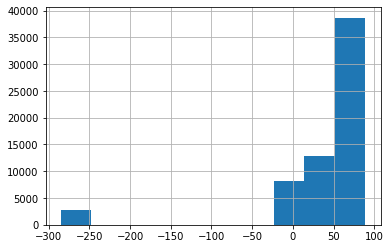

In [ ]:
df['AGE'].hist()

  It can be seen that there are some negative values which will be corrected later

In [ ]:
df['LOS'] = df['DISCHTIME'].sub(df['ADMITTIME']) / np.timedelta64(1,'D') # subtract ADMITTIME from DISCHTIME and express difference in days 'D'

df['LOS']   #los was created

0         4.164583
1        11.112500
2        13.895833
3         5.634722
4         5.585417
           ...    
62472     1.872917
62473     2.502083
62474     1.609722
62475     3.710417
62476     3.100000
Name: LOS, Length: 62477, dtype: float64

#df['LengthOfStayLong']=df['LOS']>5 #creating a new column with variable > 5 which means long stay

In [ ]:
df.loc[df['LOS'] <= 7, 'LengthOfStayLong'] = 0 
df.loc[df['LOS'] > 7, 'LengthOfStayLong'] = 1 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   INSURANCE             62477 non-null  object        
 9   RELIGION              61995 non-null  object        
 10  ETHNICITY             62477 non-null  object        
 11  GENDER                62477 non-null  object        
 12  DOB                   62477 non-null  datetime64[ns]
 13  LOS_ICU         

In [ ]:
df['LengthOfStayLong'].value_counts()

0.0    31854
1.0    30623
Name: LengthOfStayLong, dtype: int64

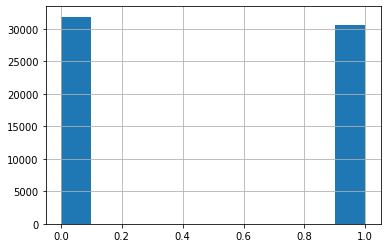

In [ ]:
df['LengthOfStayLong'].hist()

## Converting

# The length of stay varies across patients, we may normalize the total count values into daily average count values in order to retrieve the frequency of the events. Here, we compute the values and save them as new columns, and append '_DAY' to the original column names.

In [ ]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name + '_DAY'] = df[col_name] / np.maximum(np.ceil(df['LOS']), 1)

# Completing

In [ ]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name] = df[col_name].fillna(0)
  df[col_name + '_DAY'] = df[col_name + '_DAY'].fillna(0)

In [ ]:
df['DIAG_COUNT'] = df['DIAG_COUNT'].fillna(0)
df['LOS_ICU'] = df['LOS_ICU'].fillna(0)

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,INSURANCE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,AGE,LOS,LengthOfStayLong,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,None,0,ALTERED MENTAL STATUS; DYSPNEA,Medicare,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,1,1,0,1,0,0,0,0,69.0,122.0,92.772727,78.0,187.0,142.111111,22.0,99.0,56.722222,47.0,104.0,76.000000,15.0,32.0,20.875000,35.666667,37.666667,36.851852,90.0,99.0,95.086957,94.0,178.0,133.750000,60,4.164583,0.0,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,None,0,MVA;TRAUMA,Government,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,1,0,0,0,0,0,0,88.0,133.0,108.268293,97.0,175.0,119.780488,35.0,67.0,53.317073,55.0,91.0,73.948718,11.0,38.0,18.291667,36.999999,38.999998,38.388888,94.0,100.0,99.288889,115.0,115.0,115.000000,18,11.112500,1.0,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,None,0,INFECTED RIGHT FOOT,Medicare,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,0,0,0,0,0,0,0,58.0,128.0,96.522727,65.0,204.0,109.454545,26.0,104.0,57.795455,41.0,137.0,73.727273,10.0,26.0,15.500000,36.200001,37.099998,36.697619,92.0,100.0,98.380952,64.0,234.0,149.619048,70,13.895833,1.0,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,None,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,Medicare,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,1,0,1,0,0,1,0,50.0,51.0,50.038462,113.0,168.0,137.714286,37.0,55.0,44.571429,57.0,78.0,67.809524,8.0,22.0,17.038462,35.555556,36.500000,36.244444,92.0,99.0,97.346154,105.0,105.0,105.000000,-285,5.634722,0.0,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,None,0,ALTERED MENTAL STATUS,Medicare,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,1,1,0,0,0,0,1,58.0,112.0,79.285714,104.0,162.0,130.814815,46.0,85.0,60.740741,62.0,97.0,79.740741,15.0,30.0,18.875000,35.388887,37.777778,37.074074,93.0,100.0,98.827586,116.0,223.0,141.300000,76,5.585417,0.0,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 70 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   INSURANCE             62477 non-null  object        
 9   RELIGION              61995 non-null  object        
 10  ETHNICITY             62477 non-null  object        
 11  GENDER                62477 non-null  object        
 12  DOB                   62477 non-null  datetime64[ns]
 13  LOS_ICU         

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 74 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   INSURANCE             62477 non-null  object        
 9   RELIGION              61995 non-null  object        
 10  ETHNICITY             62477 non-null  object        
 11  GENDER                62477 non-null  object        
 12  DOB                   62477 non-null  datetime64[ns]
 13  LOS_ICU         

In [ ]:
df['HeartRate_Mean'].mean()

91.70463753355018

In [ ]:
df['HeartRate_Min'].mean()

77.49956963830152

In [ ]:
  df['HeartRate_Max'].mean()        #HeartRate_Max

109.7233352526241

In [ ]:
  df['SysBP_Min'].mean()

92.09204596777178

In [ ]:
  df['SysBP_Max'].mean()

149.32127684005053

In [ ]:
  df['SysBP_Mean'].mean()

118.88986413741272

In [ ]:
  df['DiasBP_Min'].mean()

43.586643956212065

In [ ]:
  df['DiasBP_Max'].mean()

83.58437954528057

In [ ]:
  df['DiasBP_Mean'].mean()

60.63879568019436

In [ ]:
  df['MeanBP_Min'].mean()

58.310359673363145

In [ ]:
  df['MeanBP_Max'].mean()

104.69027937516442

In [ ]:
  df['MeanBP_Mean'].mean()

77.90612352575934

In [ ]:
  df['RespRate_Min'].mean()

12.364434892499672

In [ ]:
  df['RespRate_Max'].mean()

27.27540255413659

In [ ]:
  df['RespRate_Mean'].mean()

18.853712977630167

In [ ]:
  df['TempC_Min'].mean()

36.09535478379251

In [ ]:
  df['TempC_Max'].mean()

37.47081600441541

In [ ]:
  df['TempC_Mean'].mean()

36.81708747439377

In [ ]:
  df['SpO2_Min'].mean()

91.4061886163917

In [ ]:
  df['SpO2_Max'].mean()

99.54642850302442

In [ ]:
  df['SpO2_Mean'].mean()

97.13475552859231

In [ ]:
  df['Glucose_Min'].mean()

106.54427687720558

In [ ]:
  df['Glucose_Max'].mean()

195.7783585891944

In [ ]:
  df['Glucose_Mean'].mean()

148.22670134372686

In [ ]:
df['HeartRate_Mean'] = df['HeartRate_Mean'].fillna(91.704)


In [ ]:
df['HeartRate_Min'] = df['HeartRate_Min'].fillna(77.499)

In [ ]:
df['HeartRate_Max'] = df['HeartRate_Max'].fillna(109.723)

In [ ]:
df['SysBP_Min']=df['SysBP_Min'].fillna(92.092)

In [ ]:
df['SysBP_Max']=df['SysBP_Max'].fillna(149.321)

In [ ]:
df['SysBP_Mean']=df['SysBP_Mean'].fillna(118.889)

In [ ]:
 df['DiasBP_Min']=df['DiasBP_Min'].fillna(43.586)

In [ ]:
 df['DiasBP_Max']=df['DiasBP_Max'].fillna(83.584)

In [ ]:
 df['DiasBP_Mean']=df['DiasBP_Mean'].fillna(60.638)

In [ ]:
 df['MeanBP_Min']=df['MeanBP_Min'].fillna(58.310)

In [ ]:
 df['MeanBP_Max']=df['MeanBP_Max'].fillna(104.690)

In [ ]:
 df['MeanBP_Mean']=df['MeanBP_Mean'].fillna(77.906)

In [ ]:
 df['RespRate_Min']=df['RespRate_Min'].fillna(12.364)

In [ ]:
 df['RespRate_Max']=df['RespRate_Max'].fillna(27.275)

In [ ]:
 df['RespRate_Mean']=df['RespRate_Mean'].fillna(18.853)

In [ ]:
 df['TempC_Min']=df['TempC_Min'].fillna(36.095)

In [ ]:
 df['TempC_Max']=df['TempC_Max'].fillna(37.4708)

In [ ]:
 df['TempC_Mean']=df['TempC_Mean'].fillna(36.817)

In [ ]:
 df['SpO2_Min']=df['SpO2_Min'].fillna(91.406)

In [ ]:
 df['SpO2_Max']=df['SpO2_Max'].fillna(99.546)

In [ ]:
 df['SpO2_Mean']=df['SpO2_Mean'].fillna(97.134)

In [ ]:
   df['Glucose_Min']=df['Glucose_Min'].fillna(106.544)  #Glucose_Min

In [ ]:
df['Glucose_Max']=df['Glucose_Max'].fillna(195.778)

In [ ]:
df['Glucose_Mean']=df['Glucose_Mean'].fillna(148.2267)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 70 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   INSURANCE             62477 non-null  object        
 9   RELIGION              61995 non-null  object        
 10  ETHNICITY             62477 non-null  object        
 11  GENDER                62477 non-null  object        
 12  DOB                   62477 non-null  datetime64[ns]
 13  LOS_ICU         

Now For categorical variables

In [ ]:
df['RELIGION'].value_counts(dropna = False)

CATHOLIC                  21956
NOT SPECIFIED             12375
UNOBTAINABLE               8573
PROTESTANT QUAKER          7661
JEWISH                     5656
OTHER                      2862
EPISCOPALIAN                816
GREEK ORTHODOX              482
NaN                         482
CHRISTIAN SCIENTIST         453
BUDDHIST                    289
MUSLIM                      244
JEHOVAH'S WITNESS           146
UNITARIAN-UNIVERSALIST      132
HINDU                       116
ROMANIAN EAST. ORTH          93
7TH DAY ADVENTIST            86
BAPTIST                      28
HEBREW                       18
METHODIST                     8
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [ ]:
df['RELIGION'] = df['RELIGION'].fillna('NOT SPECIFIED')

In [ ]:
df['RELIGION'].value_counts(dropna = False) # no more NaN's!

CATHOLIC                  21956
NOT SPECIFIED             12857
UNOBTAINABLE               8573
PROTESTANT QUAKER          7661
JEWISH                     5656
OTHER                      2862
EPISCOPALIAN                816
GREEK ORTHODOX              482
CHRISTIAN SCIENTIST         453
BUDDHIST                    289
MUSLIM                      244
JEHOVAH'S WITNESS           146
UNITARIAN-UNIVERSALIST      132
HINDU                       116
ROMANIAN EAST. ORTH          93
7TH DAY ADVENTIST            86
BAPTIST                      28
HEBREW                       18
METHODIST                     8
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 70 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   INSURANCE             62477 non-null  object        
 9   RELIGION              62477 non-null  object        
 10  ETHNICITY             62477 non-null  object        
 11  GENDER                62477 non-null  object        
 12  DOB                   62477 non-null  datetime64[ns]
 13  LOS_ICU         

In [ ]:
df.loc[df['AGE'] < 0, 'AGE'] = 90

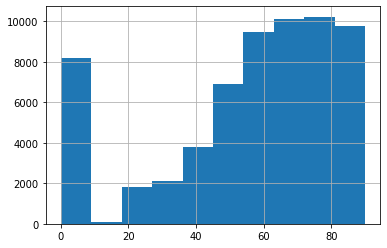

In [ ]:
df['AGE'].hist()

## Converting. One end encoding

In [ ]:
tmp_df_admissions = pd.get_dummies(df['ADMISSION_TYPE'], prefix = 'ADMISSION_TYPE')
tmp_df_admissions

,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
62472,0,1,0,0
62473,0,1,0,0
62474,0,1,0,0
62475,0,1,0,0


In [ ]:
df = pd.concat([df, tmp_df_admissions], axis = 1) 
# add the above temporary dataframe to the original dataframe, axis = 1 specifies that we want to stack them horizontally not vertically

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 74 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SUBJECT_ID                62477 non-null  int64         
 1   HADM_ID                   62477 non-null  int64         
 2   ADMISSION_TYPE            62477 non-null  object        
 3   ADMITTIME                 62477 non-null  datetime64[ns]
 4   DISCHTIME                 62477 non-null  datetime64[ns]
 5   DEATHTIME                 6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG      62477 non-null  int64         
 7   DIAGNOSIS                 62452 non-null  object        
 8   INSURANCE                 62477 non-null  object        
 9   RELIGION                  62477 non-null  object        
 10  ETHNICITY                 62477 non-null  object        
 11  GENDER                    62477 non-null  object        
 12  DOB               

In [ ]:
df['GENDER'].value_counts()

M    34986
F    27491
Name: GENDER, dtype: int64

In [ ]:
df['GENDER_F'] = (df['GENDER'] == 'F') * 1

In [ ]:
df['GENDER_F'].value_counts() #0 STANDS FOR MAKE AND 1 STANDS FOR FEMALE

0    34986
1    27491
Name: GENDER_F, dtype: int64

In [ ]:
tmp_categories = list(df['RELIGION'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['RELIGION'].astype(tmp_categories_dtype).fillna('OTHERS') 
tmp_df = pd.get_dummies(tmp_df, prefix = 'RELIGION') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
62472,0,0,1,0
62473,0,0,0,1
62474,0,1,0,0
62475,0,1,0,0


In [ ]:
tmp_categories = list(df['INSURANCE'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['INSURANCE'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'INSURANCE') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS
0,1,0,0,0
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
62472,0,1,0,0
62473,0,0,1,0
62474,0,1,0,0
62475,1,0,0,0


In [ ]:
tmp_categories = list(df['ETHNICITY'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['ETHNICITY'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'ETHNICITY') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
62472,0,0,1,0
62473,0,0,0,1
62474,1,0,0,0
62475,0,0,1,0


### Save your pre-processed dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 87 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   SUBJECT_ID                        62477 non-null  int64         
 1   HADM_ID                           62477 non-null  int64         
 2   ADMISSION_TYPE                    62477 non-null  object        
 3   ADMITTIME                         62477 non-null  datetime64[ns]
 4   DISCHTIME                         62477 non-null  datetime64[ns]
 5   DEATHTIME                         6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG              62477 non-null  int64         
 7   DIAGNOSIS                         62452 non-null  object        
 8   INSURANCE                         62477 non-null  object        
 9   RELIGION                          62477 non-null  object        
 10  ETHNICITY                         62477 non-nu

In [ ]:
# Grant access to your Google Drive. You would need to authenicate once again
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [ ]:
df.to_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv', index = False)

NameError: ignored

In [ ]:
pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,INSURANCE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,AGE,LOS,LengthOfStayLong,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS,ETHNICITY_WHITE.1,ETHNICITY_BLACK/AFRICAN AMERICAN.1,ETHNICITY_UNKNOWN/NOT SPECIFIED.1,ETHNICITY_OTHERS.1
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,0,ALTERED MENTAL STATUS; DYSPNEA,Medicare,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,1,1,0,1,0,0,0,0,69.0,122.0,92.772727,78.0,187.0,142.111111,22.0,...,90.0,99.0,95.086957,94.0,178.0,133.750000,60,4.164583,0.0,0.200000,8.800000,0.200000,1.400000,36.400000,0.000000,3.600000,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,0,MVA;TRAUMA,Government,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,1,0,0,0,0,0,0,88.0,133.0,108.268293,97.0,175.0,119.780488,35.0,...,94.0,100.0,99.288889,115.0,115.0,115.000000,18,11.112500,1.0,0.000000,0.000000,0.750000,0.000000,34.000000,27.583333,0.000000,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,0,INFECTED RIGHT FOOT,Medicare,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,0,0,0,0,0,0,0,58.0,128.0,96.522727,65.0,204.0,109.454545,26.0,...,92.0,100.0,98.380952,64.0,234.0,149.619048,70,13.895833,1.0,0.000000,0.000000,0.571429,0.000000,41.000000,27.857143,0.000000,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,Medicare,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,1,0,1,0,0,1,0,50.0,51.0,50.038462,113.0,168.0,137.714286,37.0,...,92.0,99.0,97.346154,105.0,105.0,105.000000,90,5.634722,0.0,0.166667,5.000000,0.333333,1.333333,34.500000,0.000000,3.500000,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,0,ALTERED MENTAL STATUS,Medicare,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,1,1,0,0,0,0,1,58.0,112.0,79.285714,104.0,162.0,130.814815,46.0,...,93.0,100.0,98.827586,116.0,223.0,141.300000,76,5.585417,0.0,0.000000,8.833333,1.000000,1.666667,63.000000,27.500000,0.000000,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62472,31355,146717,EMERGENCY,2110-07-28 22:03:00,2110-07-30 19:00:00,NaN,0,NECROTIZING PANCREATITIS,Private,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,M,2071-09-27,0.8021,1.0,2,61.0,0.0,1.0,134.0,42.0,0.0,21.0,3,2.0,0,0,0,0,0,0,0,0,105.0,147.0,

In [ ]:
 df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'INSURANCE',
       'RELIGION', 'ETHNICITY', 'GENDER', 'DOB', 'LOS_ICU', 'CALLOUT_COUNT',
       'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT',
       'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT', 'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL',
       'HEPATIC', 'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'AGE', 'LOS', 'LengthOfStayLong', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY',
       'PROC_COUNT_DAY

## PREDICTION TARGET "LengthOfStayLong"

In [ ]:
df['LengthOfStayLong'].value_counts()

0.0    31854
1.0    30623
Name: LengthOfStayLong, dtype: int64

In [ ]:
# visualization package
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df[['GENDER', 'LengthOfStayLong']].groupby(['GENDER']).mean()

,LengthOfStayLong
GENDER,
F,0.486996
M,0.492626


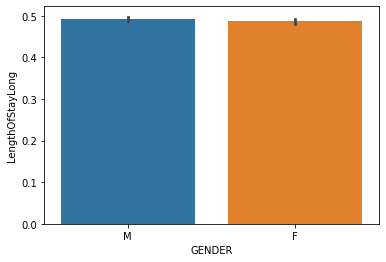

In [ ]:
sns.barplot(x = 'GENDER', y = 'LengthOfStayLong', data = df)

In [ ]:
df[['ADMISSION_TYPE', 'LengthOfStayLong']].groupby(['ADMISSION_TYPE']).mean()

,LengthOfStayLong
ADMISSION_TYPE,
ELECTIVE,0.484848
EMERGENCY,0.519261
NEWBORN,0.309256
URGENT,0.604603


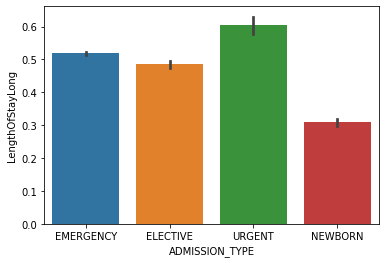

In [ ]:
sns.barplot(x = 'ADMISSION_TYPE', y = 'LengthOfStayLong', data = df)

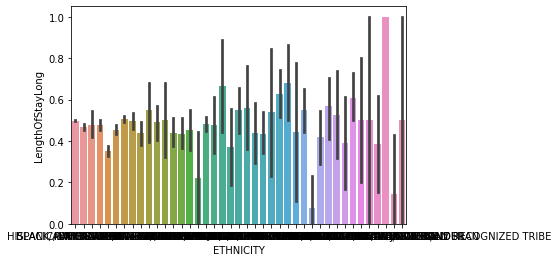

In [ ]:
sns.barplot(x = 'ETHNICITY', y = 'LengthOfStayLong', data = df)

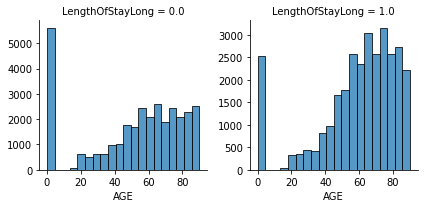

In [ ]:
g = sns.FacetGrid(df, col = 'LengthOfStayLong', sharey = False)
g.map(sns.histplot, 'AGE', bins = 20)

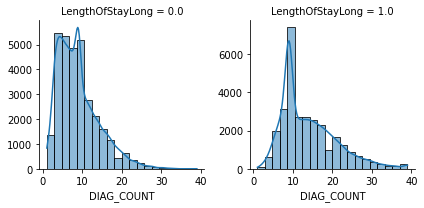

In [ ]:
g = sns.FacetGrid(df, col = 'LengthOfStayLong', sharey = False)
g.map(sns.histplot, 'DIAG_COUNT', bins = 20, kde = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 91 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SUBJECT_ID                          62477 non-null  int64  
 1   HADM_ID                             62477 non-null  int64  
 2   ADMISSION_TYPE                      62477 non-null  object 
 3   ADMITTIME                           62477 non-null  object 
 4   DISCHTIME                           62477 non-null  object 
 5   DEATHTIME                           6624 non-null   object 
 6   HOSPITAL_EXPIRE_FLAG                62477 non-null  int64  
 7   DIAGNOSIS                           62452 non-null  object 
 8   INSURANCE                           62477 non-null  object 
 9   RELIGION                            62477 non-null  object 
 10  ETHNICITY                           62477 non-null  object 
 11  GENDER                              62477

In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'INSURANCE',
       'RELIGION', 'ETHNICITY', 'GENDER', 'DOB', 'LOS_ICU', 'CALLOUT_COUNT',
       'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT',
       'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT', 'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL',
       'HEPATIC', 'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'AGE', 'LOS', 'LengthOfStayLong', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY',
       'PROC_COUNT_DAY

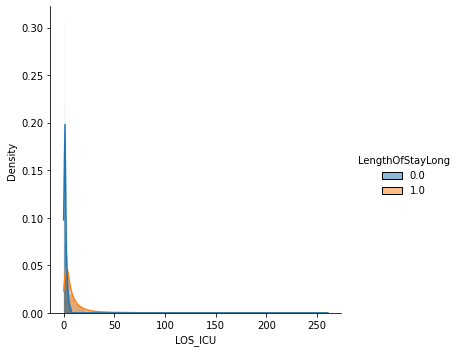

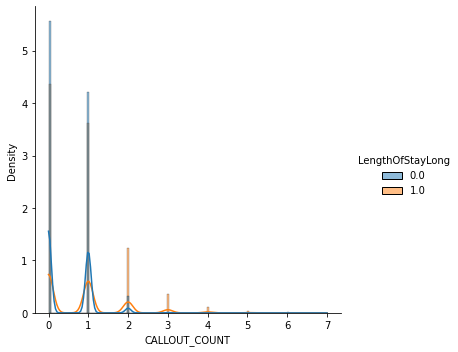

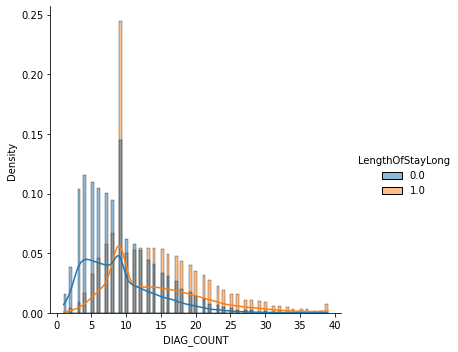

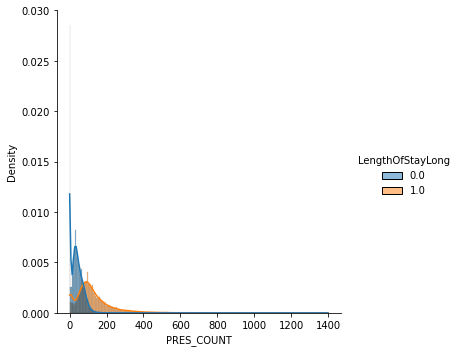

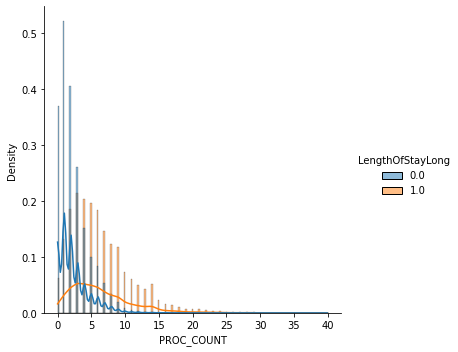

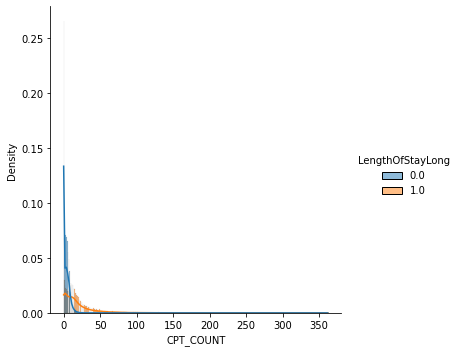

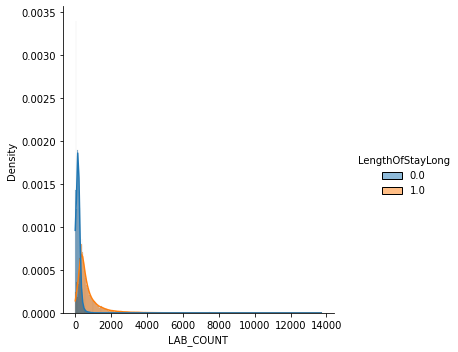

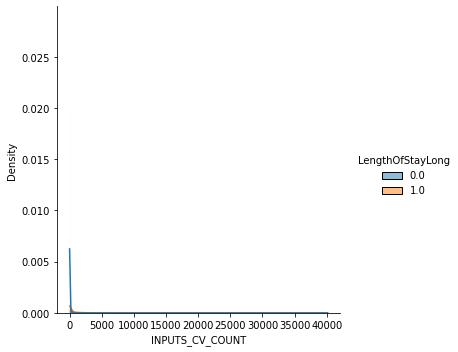

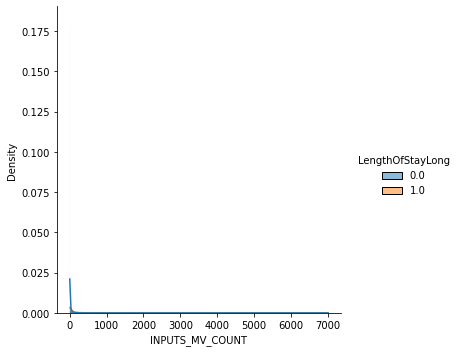

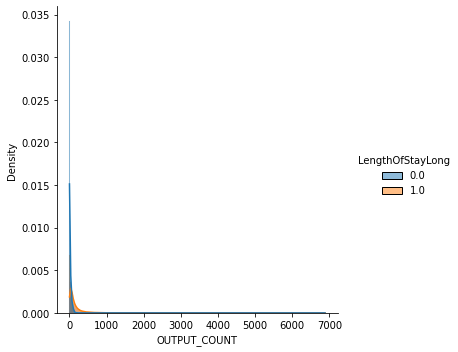

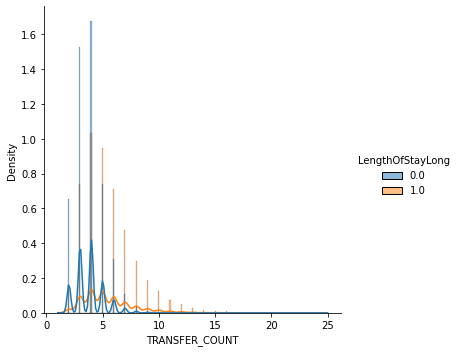

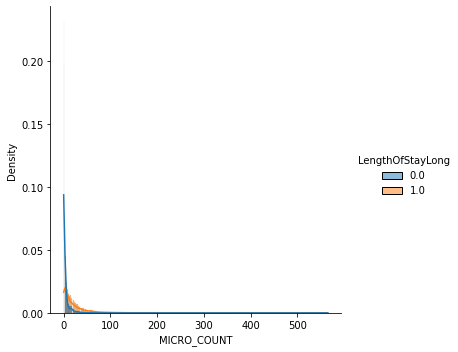

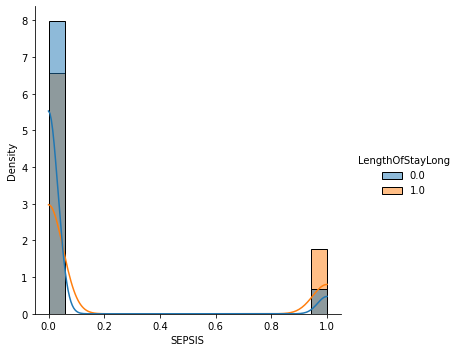

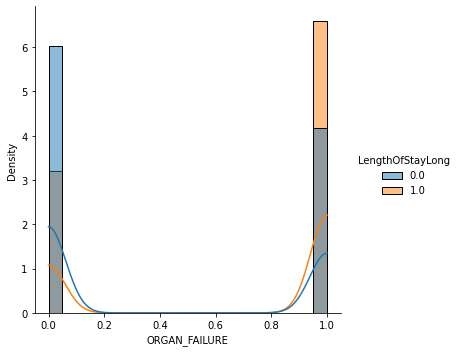

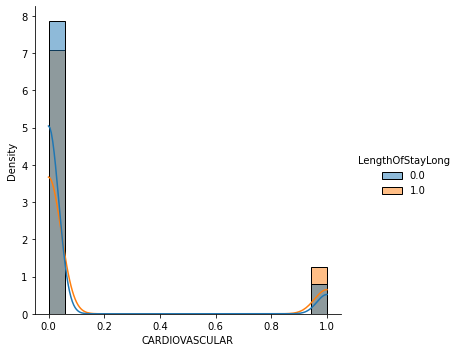

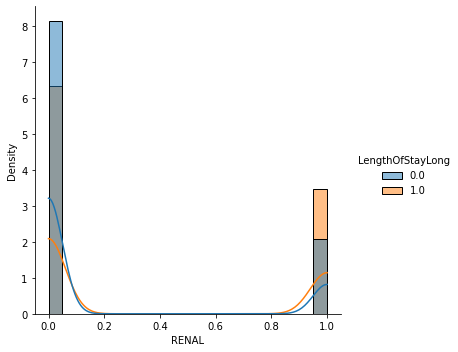

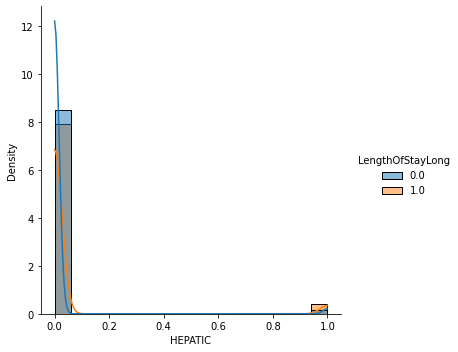

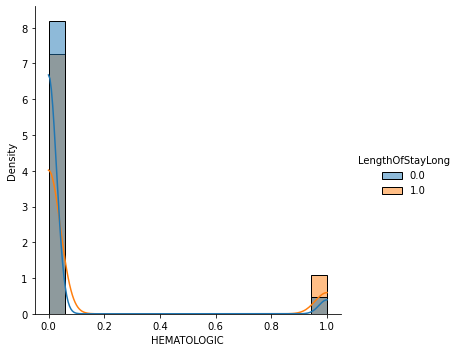

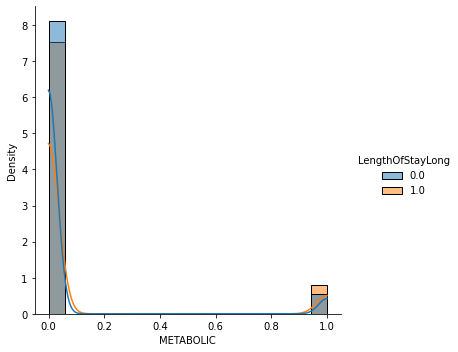

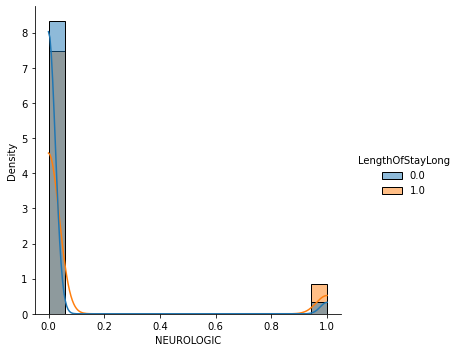

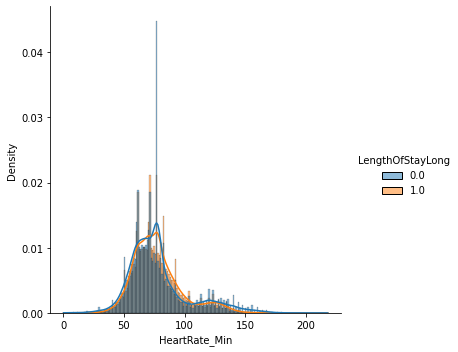

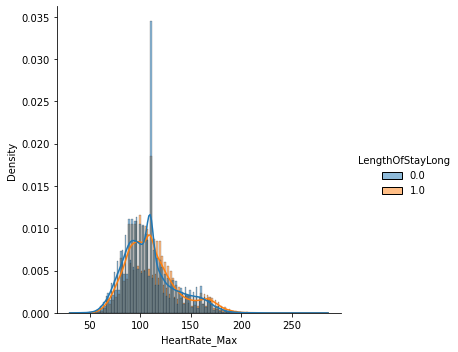

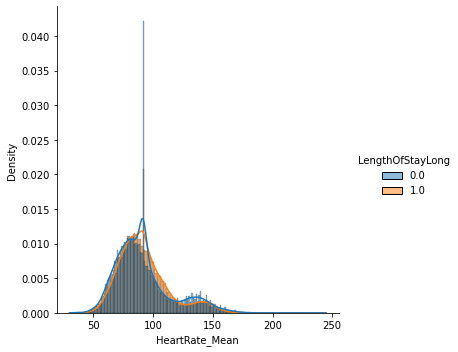

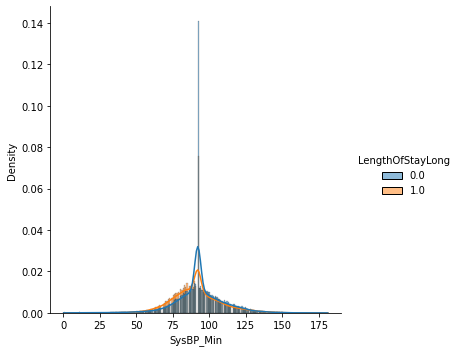

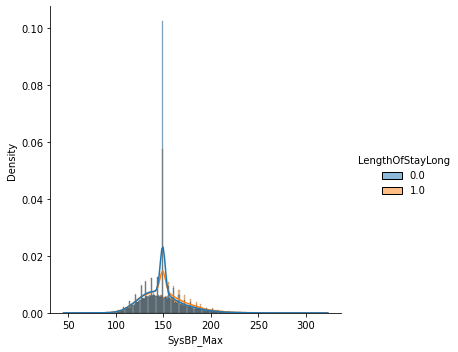

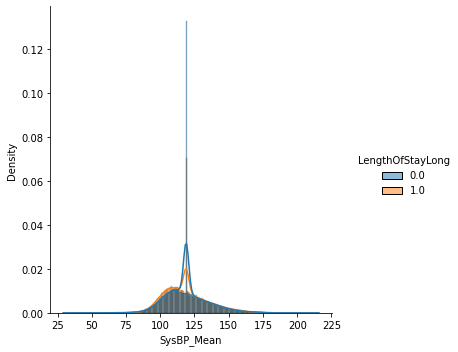

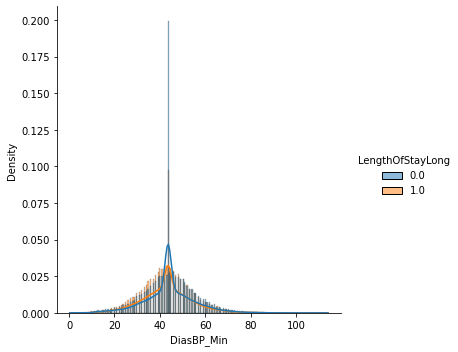

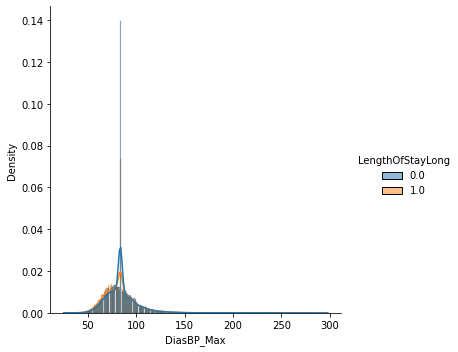

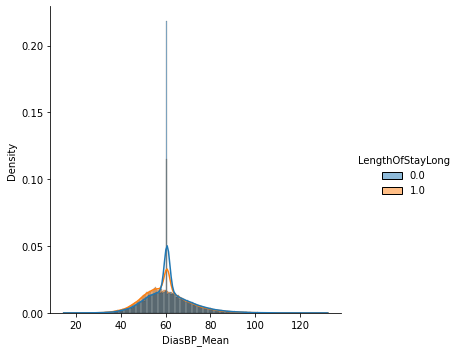

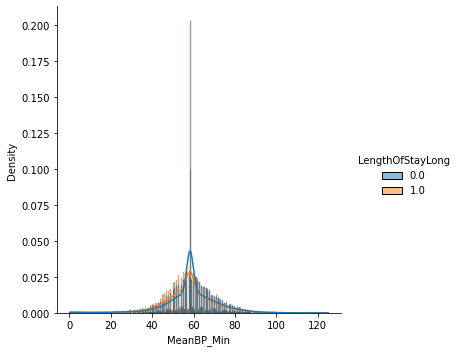

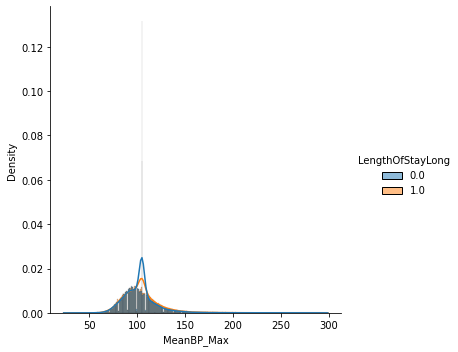

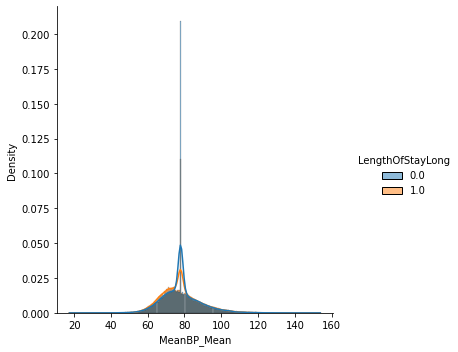

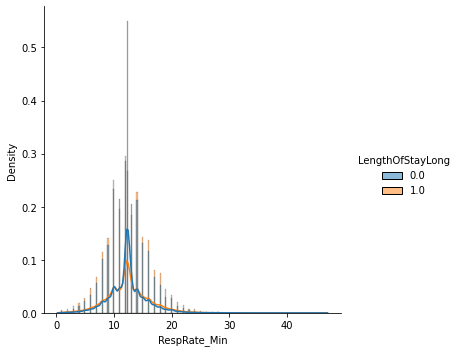

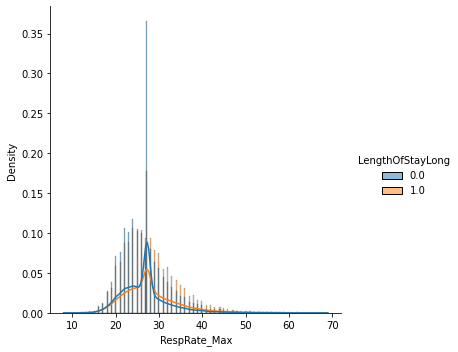

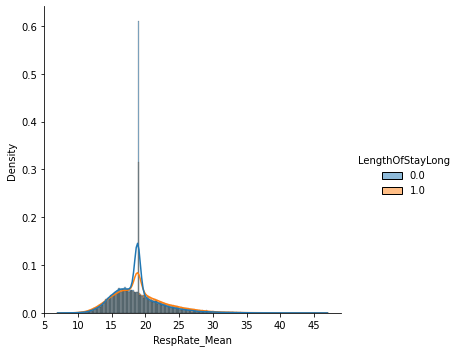

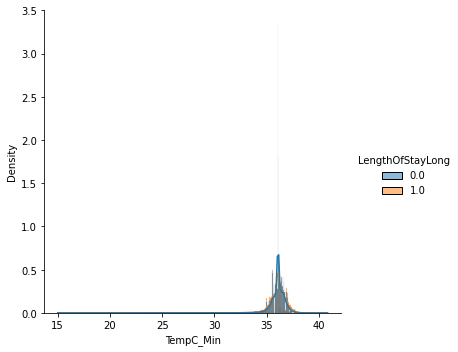

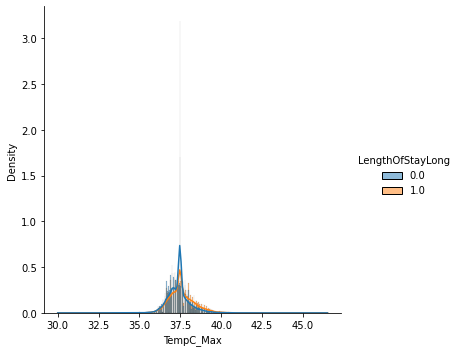

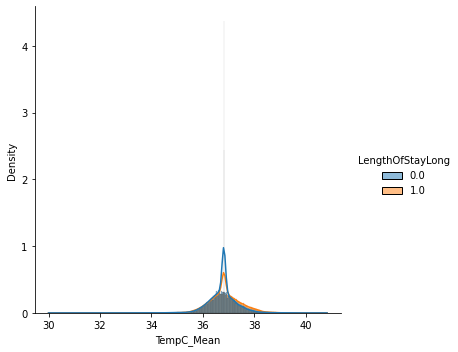

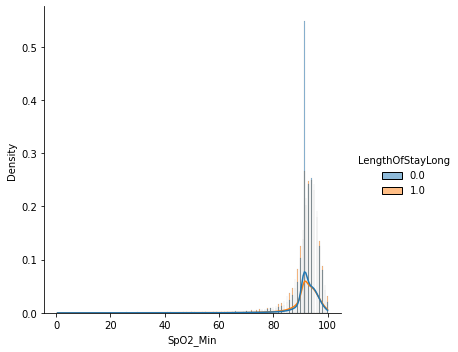

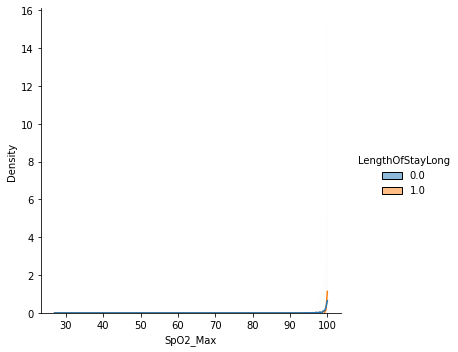

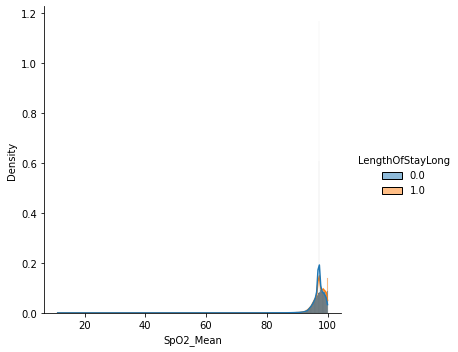

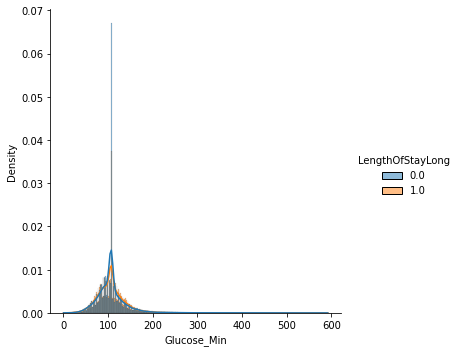

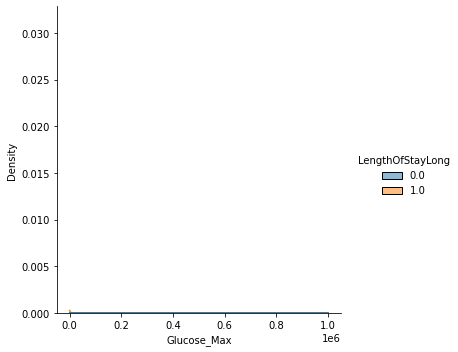

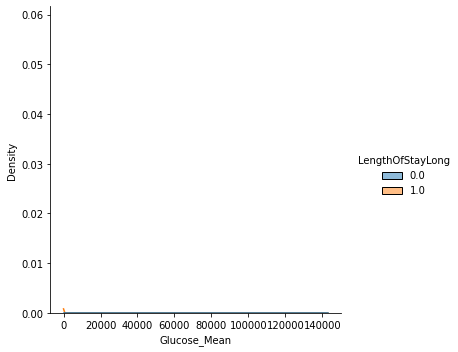

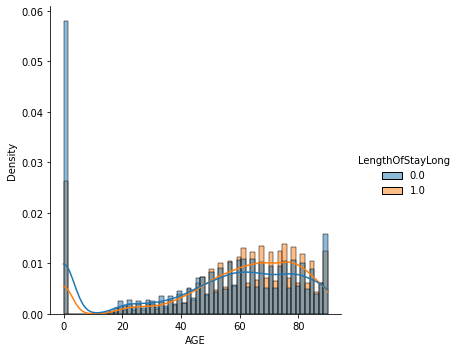

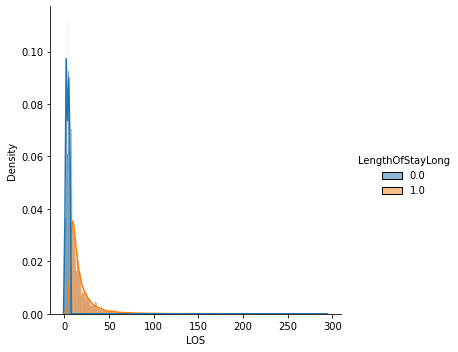

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


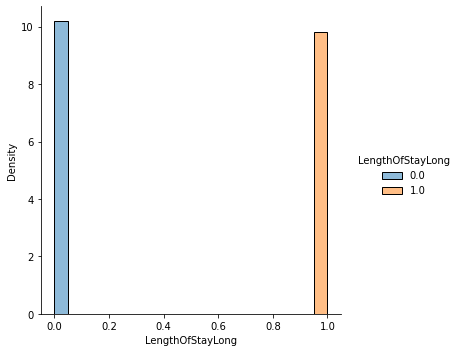

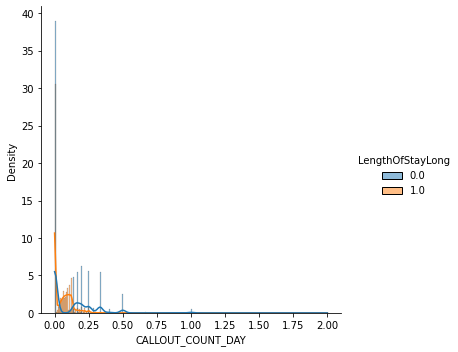

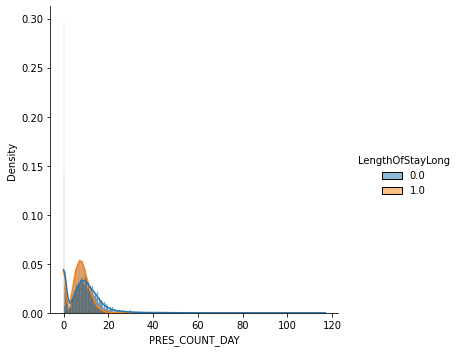

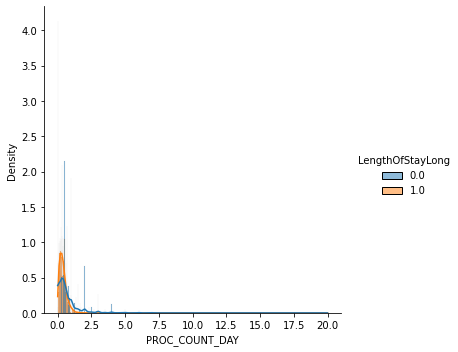

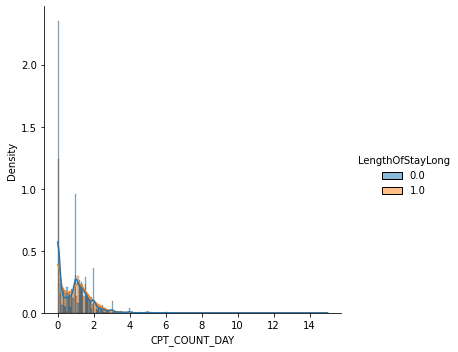

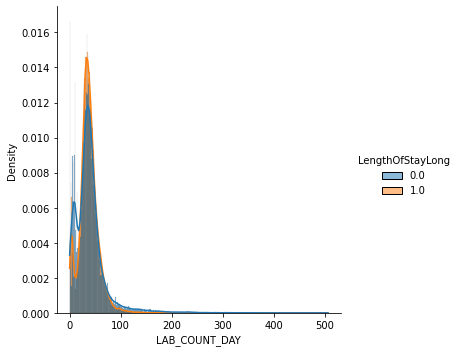

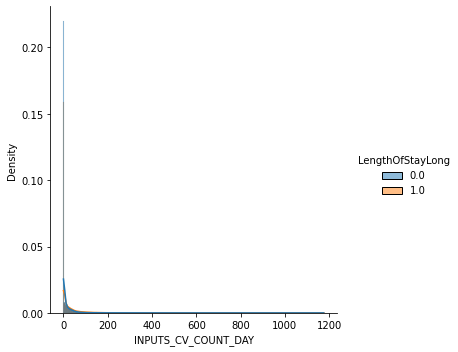

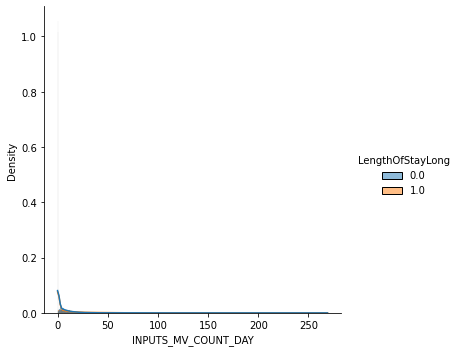

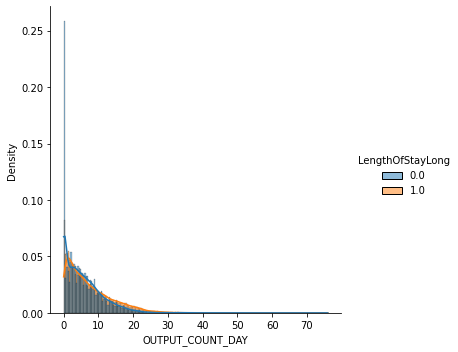

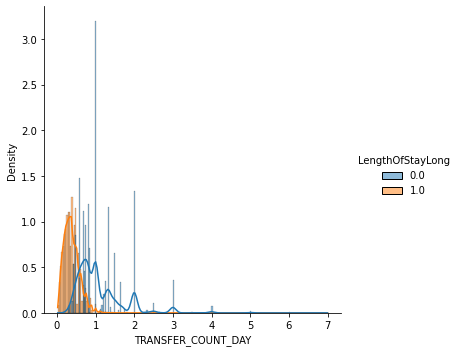

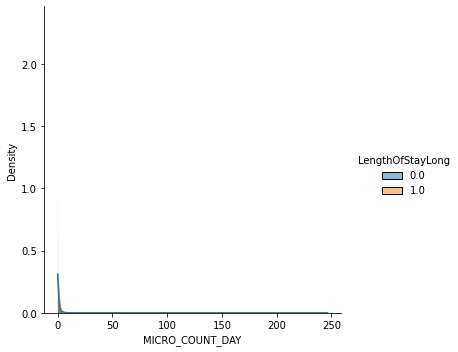

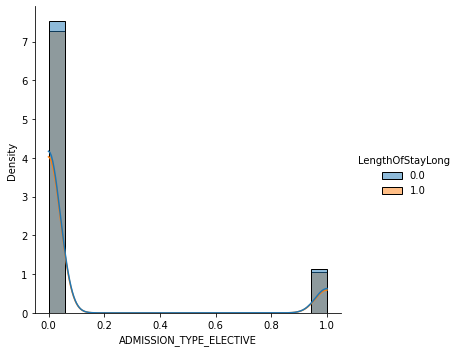

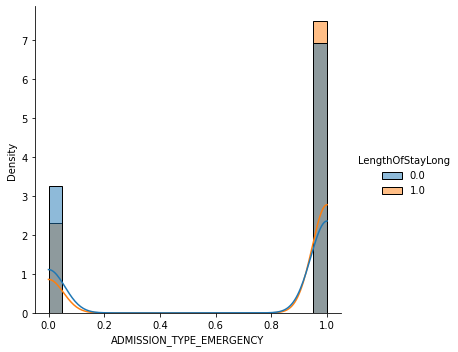

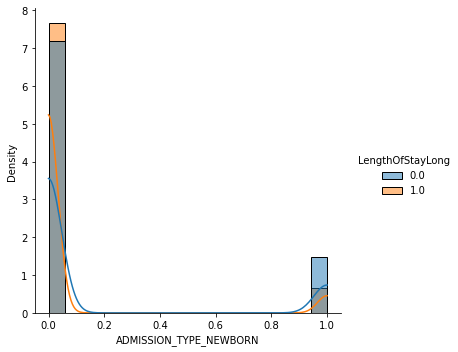

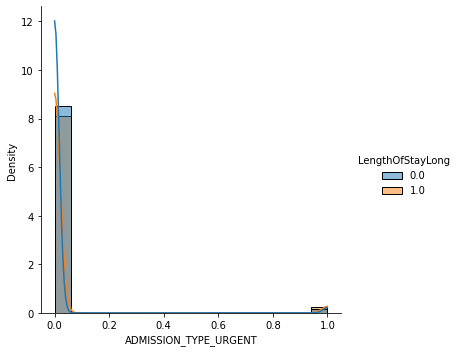

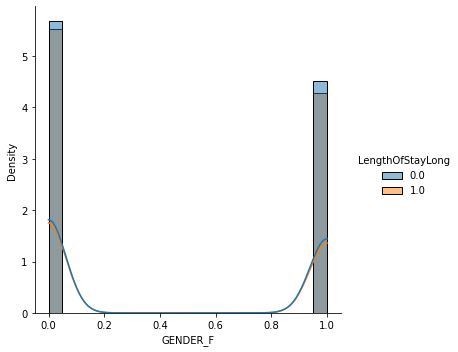

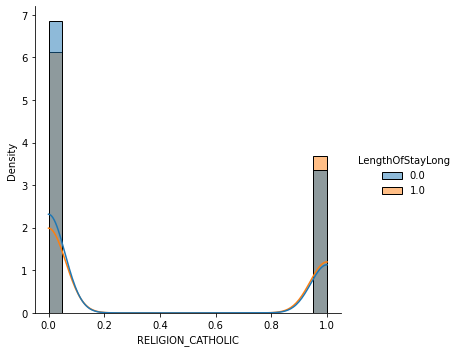

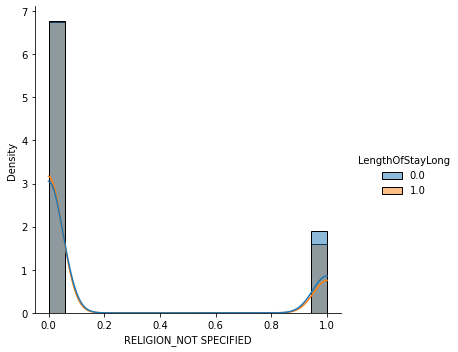

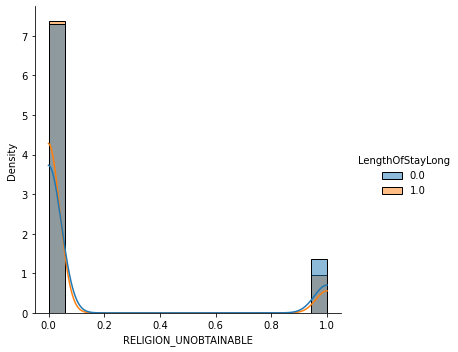

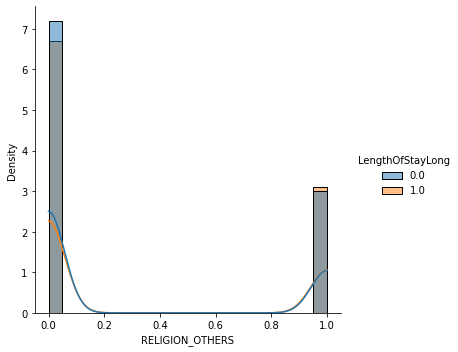

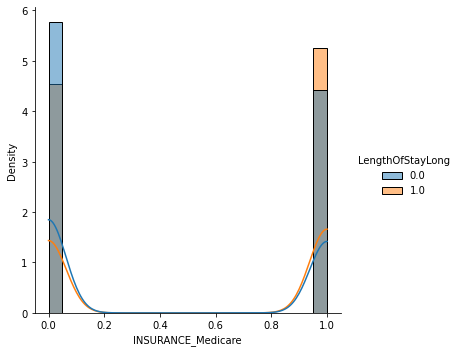

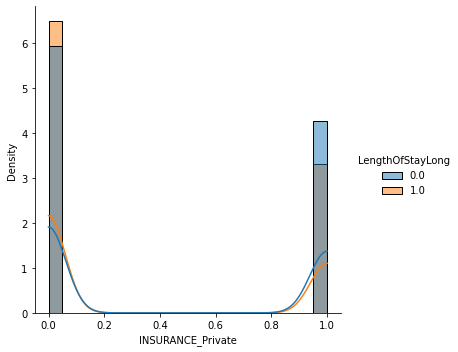

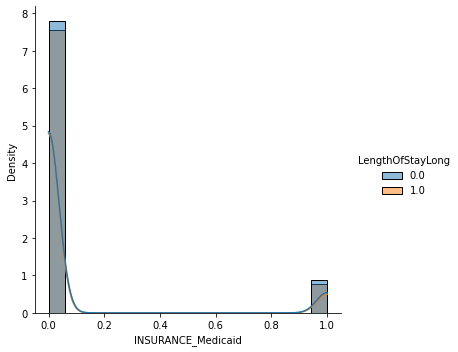

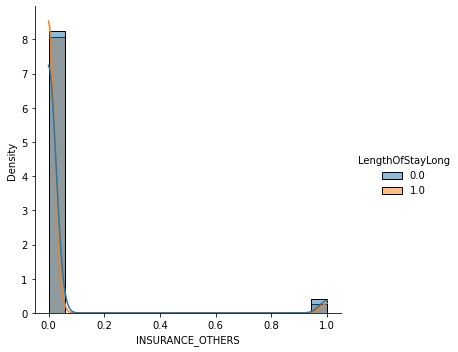

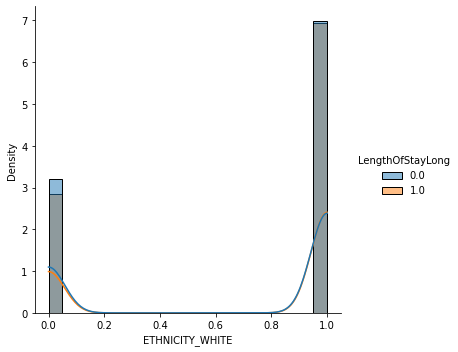

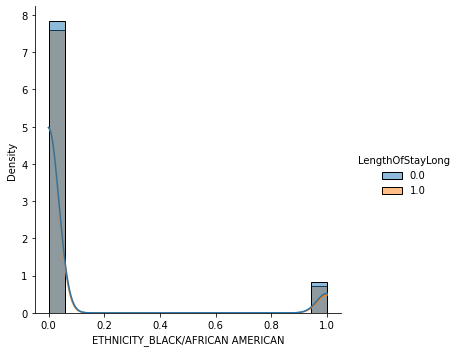

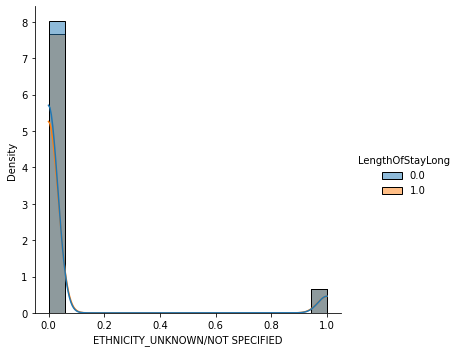

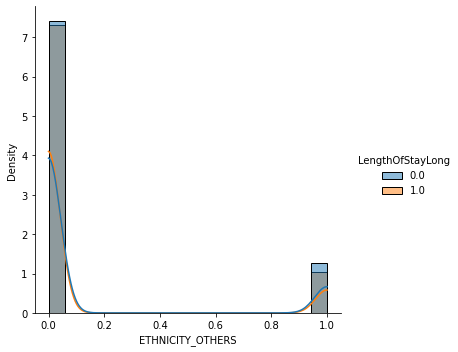

In [ ]:
numerical_feaures = ['LOS_ICU', 'CALLOUT_COUNT',
       'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT',
       'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT', 'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL',
       'HEPATIC', 'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'AGE', 'LOS', 'LengthOfStayLong', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY',
       'PROC_COUNT_DAY', 'CPT_COUNT_DAY', 'LAB_COUNT_DAY',
       'INPUTS_CV_COUNT_DAY', 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY',
       'TRANSFER_COUNT_DAY', 'MICRO_COUNT_DAY', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'GENDER_F', 'RELIGION_CATHOLIC',
       'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS',
       'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid',
       'INSURANCE_OTHERS', 'ETHNICITY_WHITE',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED',
       'ETHNICITY_OTHERS']

for col_name in numerical_feaures:
  sns.displot(data = df, x = col_name, hue = 'LengthOfStayLong', stat = 'density', kde = True)
  plt.show()

# Machine learning (Supervsed Learning)

# Importing packages for data handling and visualization

> Indented block



In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


# Packages for data analysis and modelling

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix, plot_roc_curve, mean_squared_error, r2_score

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'


Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 91 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SUBJECT_ID                          62477 non-null  int64  
 1   HADM_ID                             62477 non-null  int64  
 2   ADMISSION_TYPE                      62477 non-null  object 
 3   ADMITTIME                           62477 non-null  object 
 4   DISCHTIME                           62477 non-null  object 
 5   DEATHTIME                           6624 non-null   object 
 6   HOSPITAL_EXPIRE_FLAG                62477 non-null  int64  
 7   DIAGNOSIS                           62452 non-null  object 
 8   INSURANCE                           62477 non-null  object 
 9   RELIGION                            62477 non-null  object 
 10  ETHNICITY                           62477 non-null  object 
 11  GENDER                              62477

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,INSURANCE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,AGE,LOS,LengthOfStayLong,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS,ETHNICITY_WHITE.1,ETHNICITY_BLACK/AFRICAN AMERICAN.1,ETHNICITY_UNKNOWN/NOT SPECIFIED.1,ETHNICITY_OTHERS.1
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,0,ALTERED MENTAL STATUS; DYSPNEA,Medicare,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,1,1,0,1,0,0,0,0,69.0,122.0,92.772727,78.0,187.0,142.111111,22.0,...,90.0,99.0,95.086957,94.0,178.0,133.750000,60,4.164583,0.0,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,0,MVA;TRAUMA,Government,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,1,0,0,0,0,0,0,88.0,133.0,108.268293,97.0,175.0,119.780488,35.0,...,94.0,100.0,99.288889,115.0,115.0,115.000000,18,11.112500,1.0,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,0,INFECTED RIGHT FOOT,Medicare,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,0,0,0,0,0,0,0,58.0,128.0,96.522727,65.0,204.0,109.454545,26.0,...,92.0,100.0,98.380952,64.0,234.0,149.619048,70,13.895833,1.0,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,Medicare,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,1,0,1,0,0,1,0,50.0,51.0,50.038462,113.0,168.0,137.714286,37.0,...,92.0,99.0,97.346154,105.0,105.0,105.000000,90,5.634722,0.0,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,0,ALTERED MENTAL STATUS,Medicare,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,1,1,0,0,0,0,1,58.0,112.0,79.285714,104.0,162.0,130.814815,46.0,...,93.0,100.0,98.827586,116.0,223.0,141.300000,76,5.585417,0.0,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0


# Here, LengthOfStayLong is the prediction target and we are going to use 85 columns for that

In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'INSURANCE',
       'RELIGION', 'ETHNICITY', 'GENDER', 'DOB', 'LOS_ICU', 'CALLOUT_COUNT',
       'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT',
       'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT', 'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL',
       'HEPATIC', 'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'AGE', 'LOS', 'LengthOfStayLong', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY',
       'PROC_COUNT_DAY

In [ ]:
features_list = ['SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL',
       'HEPATIC', 'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'AGE', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY',
       'PROC_COUNT_DAY', 'CPT_COUNT_DAY', 'LAB_COUNT_DAY',
       'INPUTS_CV_COUNT_DAY', 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY',
        'MICRO_COUNT_DAY', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'GENDER_F', 'RELIGION_CATHOLIC',
       'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS',
       'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid',
       'INSURANCE_OTHERS', 'ETHNICITY_WHITE',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED',
       'ETHNICITY_OTHERS']

len(features_list)

59

In [ ]:
X = df[features_list]
y = df['LengthOfStayLong']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,  # 20% of data belongs to the test set
                                                    random_state = 1, # make sure the split is the same across different devices for illustrative purposes
                                                    stratify = y)     # ensure the number of positive examples in the train and test sets are similar

In [ ]:
X_train.shape


(43733, 59)

In [ ]:
X_test.shape

(18744, 59)

# So for our analysis the train data is 43733 ad test data is 18744

# Logistic Regression
In this example, we would be utilizing the package package Scikit-learn heavily for modelling. In Scikit-learn, the general flow can be simplified as follows:

Specify a model to be trained
Choose a type of model based on your task and dataset. A full list of available models in the package can be found here.
Set the hyperparameters of the model.
Assign the model to a variable.
Train the model
Call the .fit() function using your cleaned train dataset.
Make predictions
## Call the .predict() function using your cleaned test dataset.

## Model Training and Prediction



In [ ]:
# 1. Specify a model to be trained
model_lr = LogisticRegression(random_state = 1, 
                              n_jobs = -1) # use all available CPUs within your Colab notebook for computation

In [ ]:
# 2. Train the model
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# 3. Make predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_lr

array([1., 0., 0., ..., 1., 0., 1.])

In [ ]:
model_lr.predict_proba(X_test) # the two columns represent the prob of 0 and 1 respectively

array([[0.36864619, 0.63135381],
       [0.76590587, 0.23409413],
       [0.79212156, 0.20787844],
       ...,
       [0.34751441, 0.65248559],
       [0.73303904, 0.26696096],
       [0.36006779, 0.63993221]])

In [ ]:
accuracy_score(y_test, y_pred_lr)

0.7180964575330773

In [ ]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73      9557
         1.0       0.72      0.69      0.71      9187

    accuracy                           0.72     18744
   macro avg       0.72      0.72      0.72     18744
weighted avg       0.72      0.72      0.72     18744



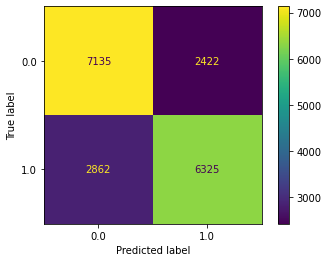

In [ ]:
plot_confusion_matrix(model_lr, X_test, y_test, values_format = 'd')
plt.show()

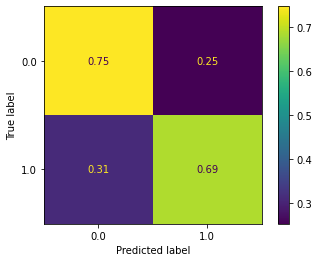

In [ ]:
# recall-related metrics
plot_confusion_matrix(model_lr, X_test, y_test, normalize = 'true') 
plt.show()

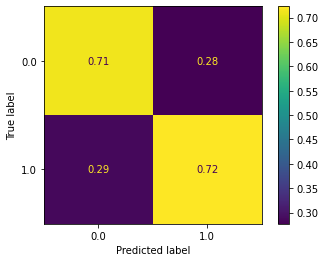

In [ ]:
# precision-related metrics
plot_confusion_matrix(model_lr, X_test, y_test, normalize = 'pred')
plt.show()

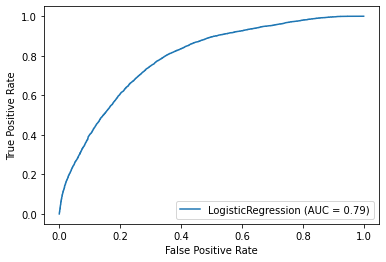

In [ ]:
plot_roc_curve(model_lr, X_test, y_test)
plt.show()

# RANDOM FOREST

In [ ]:
model_rf1 = RandomForestClassifier(n_estimators = 100, 
                                   random_state = 1,
                                   n_jobs = -1)

In [ ]:
model_rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
y_pred_rf1 = model_rf1.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      9557
         1.0       0.91      0.88      0.89      9187

    accuracy                           0.90     18744
   macro avg       0.90      0.90      0.90     18744
weighted avg       0.90      0.90      0.90     18744



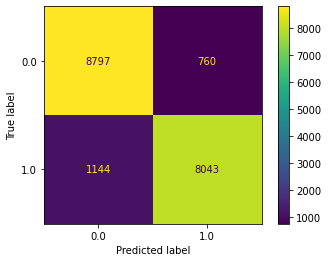

In [ ]:
plot_confusion_matrix(model_rf1, X_test, y_test, values_format = 'd')
plt.show()

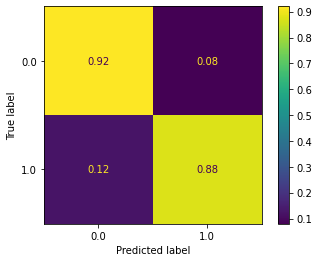

In [ ]:
plot_confusion_matrix(model_rf1, X_test, y_test, normalize = 'true') # recall
plt.show()

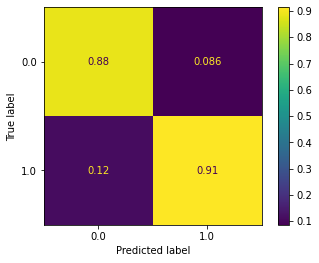

In [ ]:
plot_confusion_matrix(model_rf1, X_test, y_test, normalize = 'pred') # precision
plt.show()

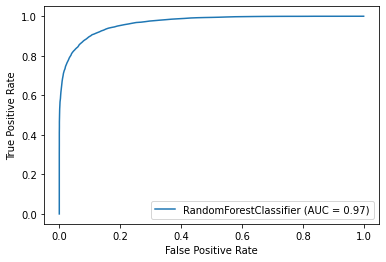

In [ ]:
plot_roc_curve(model_rf1, X_test, y_test)

In [ ]:
# a set of hyperparameters and their respective values to be tested

param_grid = {
    'n_estimators': [100, 200, 300],   # number of decision trees in the forest 
    'max_depth': [10, 40, None],       # how many times can each tree be split. None means no specific limit. 
    'class_weight': ['balanced', None] # weight of each sample. None means equal weight, balanced would put more weight on the less represented classes
}

In [ ]:
grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 1, n_jobs = -1), # define type of model to be tuned
    param_grid = param_grid,                                           # hyperparameters to be tested
    cv = 3,                                                            # 3-fold cross-validation
    scoring = 'f1',                                                    # metric to be optimized
    n_jobs = -1, 
    verbose = 2
    )

In [ ]:
grid_search_rf.fit(X_train, y_train)

# this would take 10 to 15 minutes to run
# this could take even longer depending on the number of hyperparameters to be tested, number of folds or the size of the dataset

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 11.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=1,
                                     

In [ ]:
grid_search_rf.best_params_

{'class_weight': None, 'max_depth': 40, 'n_estimators': 200}

In [ ]:
model_rf2 = grid_search_rf.best_estimator_

In [ ]:
model_rf2

# Note: this would be the same as training a seperate model using the same inputs, i.e.
# model_rf2 = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
#                                    n_jobs=-1, random_state=1)
# model_rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
pd.DataFrame(grid_search_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.291929,0.072957,0.407542,0.044842,balanced,10,100,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.873607,0.878570,0.879622,0.877267,0.002623,13
1,18.221045,0.199916,0.895365,0.053626,balanced,10,200,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.873965,0.877551,0.878698,0.876738,0.002016,14
2,27.179507,0.297874,1.301249,0.048721,balanced,10,300,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.873958,0.876354,0.878296,0.876203,0.001774,17
3,14.167767,0.285113,0.761088,0.076821,balanced,40,100,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.887957,0.893821,0.890638,0.890805,0.002397,11
4,28.465738,0.079236,1.299074,0.043779,balanced,40,200,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.888384,0.893517,0.892189,0.891363,0.002175,9
5,42.711868,0.171290,1.899829,0.054772,balanced,40,300,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.887531,0.894722,0.892556,0.891603,0.003012,5
6,14.103683,0.212841,0.655419,0.005686,balanced,None,100,"{'class_weight': 'balanced', 'max_depth': None...",0.887341,0.893486,0.890288,0.890372,0.002509,12
7,28.306133,0.294976,1.333613,0.046705,balanced,None,200,"{'class_weight': 'balanced', 'max_depth': None...",0.888715,0.893848,0.891934,0.891499,0.002118,8
8,42.505810,0.231079,1.811721,0.049015,balanced,None,300,"{'class_weight': 'balanced', 'max_depth': None...",0.887673,0.894880,0.892334,0.891629,0.002984,4
9,9.035712,0.238625,0.555933,0.001890,None,10,100,"{'class_weight': None, 'max_depth': 10, 'n_est...",0.873642,0.877399,0.879045,0.876695,0.002261,15


# EVALUATION

In [ ]:
y_pred_rf2 = model_rf2.predict(X_test)

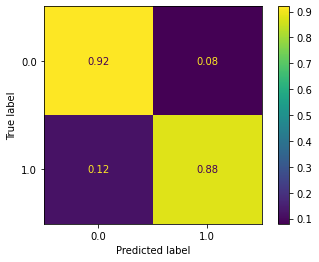

In [ ]:
plot_confusion_matrix(model_rf2, X_test, y_test, normalize = 'true') # recall
plt.show()

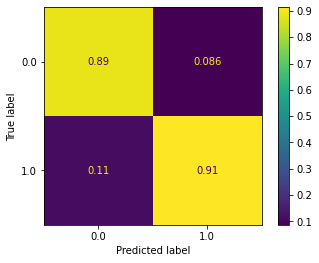

In [ ]:
plot_confusion_matrix(model_rf2, X_test, y_test, normalize = 'pred') # precision
plt.show()

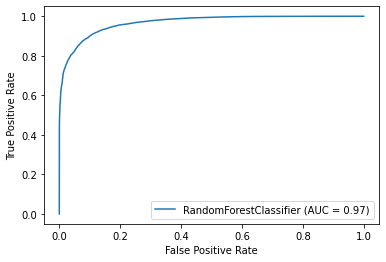

In [ ]:
plot_roc_curve(model_rf2, X_test, y_test)

In [ ]:
model_rf2_importance = pd.Series(model_rf2.feature_importances_, index = features_list)
model_rf2_importance

SEPSIS                              0.009161
ORGAN_FAILURE                       0.025131
CARDIOVASCULAR                      0.001250
RENAL                               0.005292
HEPATIC                             0.000936
HEMATOLOGIC                         0.002731
METABOLIC                           0.001075
NEUROLOGIC                          0.002106
HeartRate_Min                       0.014285
HeartRate_Max                       0.015427
HeartRate_Mean                      0.016731
SysBP_Min                           0.013721
SysBP_Max                           0.011130
SysBP_Mean                          0.011745
DiasBP_Min                          0.009744
DiasBP_Max                          0.010396
DiasBP_Mean                         0.011936
MeanBP_Min                          0.010648
MeanBP_Max                          0.010657
MeanBP_Mean                         0.010951
RespRate_Min                        0.009050
RespRate_Max                        0.010905
RespRate_M

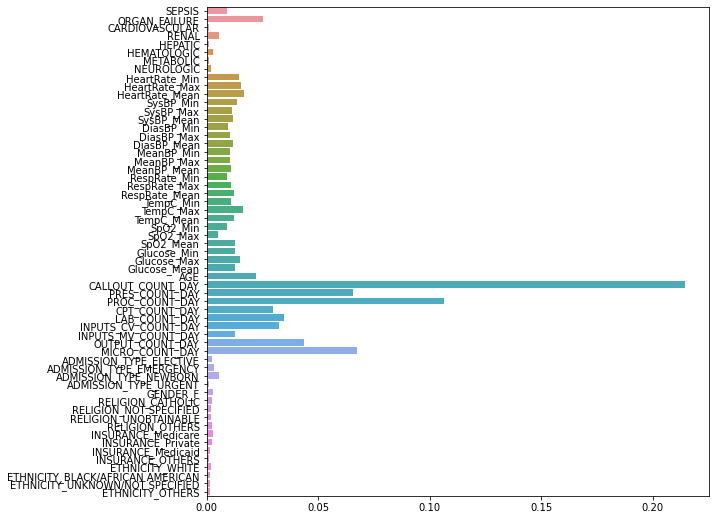

In [ ]:
plt.figure(figsize = (9, 9))
sns.barplot(x = model_rf2.feature_importances_, y = features_list)

In [ ]:
import joblib

In [ ]:
joblib.dump(model_rf2, gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib')

['/content/gdrive/MyDrive/mimic_in_hosp_mortality_model_rf2.joblib']

In [ ]:
model_rf2_loaded = joblib.load(gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib') # specify your filename here

In [ ]:
model_rf2_loaded

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)